In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from packet_utils import create_802154_phy_packet, map_nibbles_to_chips, split_iq_chips
from modulation import pulse_shape_bits_fir, half_sine_fir_taps
from filters import fractional_delay_fir_filter
from transmitter import Transmitter802154
from receiver import Receiver802154

# IEEE 802.15.4
# payload -> packet (bytes) DONE
# bytes -> chips DONE
# bits -> IQ
# Encapsulate the process in a class

# IEEE 802.15.4

## Payload -> packet (bytes, with CRC if wanted)

In [2]:
# Example values:
payload = np.array([0xAB, 0xCD], dtype=np.uint8)
append_crc = True

packet = create_802154_phy_packet(payload, append_crc=append_crc)
print("Packet bytes:")
print([hex(byte) for byte in packet])

Packet bytes:
['0x0', '0x0', '0x0', '0x0', '0xa7', '0x4', '0xab', '0xcd', '0xbe', '0x56']


## Packet bytes -> chips

In [3]:
# Chip mapping for IEEE 802.15.4 O-QPSK DSSS encoding
chip_mapping: np.ndarray = np.array(
    [
        0xD9C3522E,  # 0
        0xED9C3522,  # 1
        0x2ED9C352,  # 2
        0x22ED9C35,  # 3
        0x522ED9C3,  # 4
        0x3522ED9C,  # 5
        0xC3522ED9,  # 6
        0x9C3522ED,  # 7
        0x8C96077B,  # 8
        0xB8C96077,  # 9
        0x7B8C9607,  # A
        0x77B8C960,  # B
        0x077B8C96,  # C
        0x6077B8C9,  # D
        0x96077B8C,  # E
        0xC96077B8,  # F
    ],
    dtype=np.uint32,
)

chips = map_nibbles_to_chips(packet, chip_mapping, return_string=False)
print([hex(byte) for byte in chips])


# def binary_string_to_bit_array(binary_string: str) -> np.ndarray:
#     """Receives string of bits like '10101111_01110010' and converts it into a np.array"""
#     return np.array([int(bit) for bit in binary_string if bit in "01"], dtype=np.uint8)


# print(binary_string_to_bit_array(chips))

['0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0xd9c3522e', '0x9c3522ed', '0x7b8c9607', '0x522ed9c3', '0xd9c3522e', '0x77b8c960', '0x7b8c9607', '0x6077b8c9', '0x77b8c96', '0x96077b8c', '0x77b8c960', '0xc3522ed9', '0x3522ed9c']


## Chips -> (I_chips, Q_chips)

In [4]:
# Example usage:
I_chips, Q_chips = split_iq_chips(chips[:1])

print("I_chips:", I_chips)
print("Q_chips:", Q_chips)

I_chips: [1 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1]
Q_chips: [1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0]


## Half-sine shaping, from split chips to O-QPSK modulation

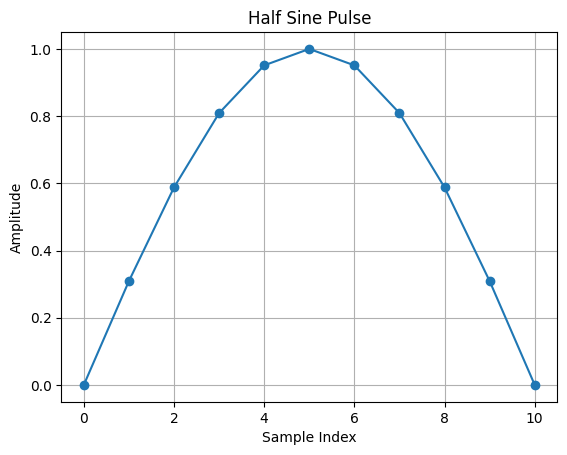

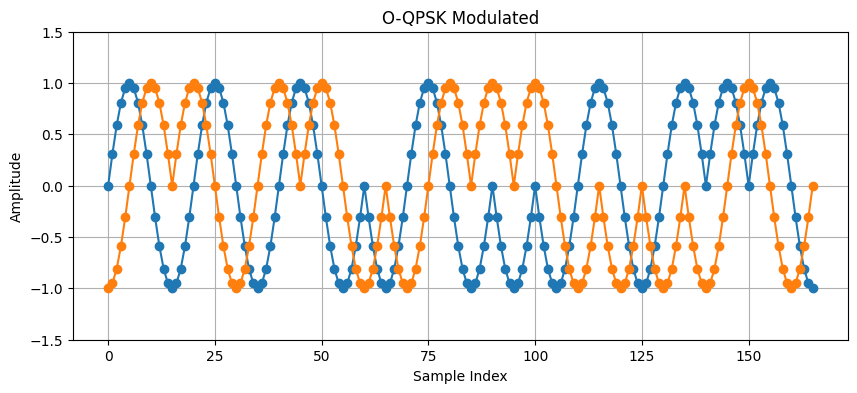

In [ ]:
sps = 10

# Generate the half-sine pulse
half_sine_pulse = half_sine_fir_taps(sps)


# Modulate input I_chips and Q_chips in quadrature, with half a symbol offset.
def oqpsk_modulate(I_chips: np.ndarray, Q_chips: np.ndarray, fir_taps: np.ndarray, sps: int) -> np.ndarray:
    """Modulate input I_chips and Q_chips in quadrature, with half a symbol offset."""
    assert I_chips.shape == Q_chips.shape, "I_chips and Q_chips must have the same size"

    # Apply pulse shaping (FIR filtering)
    # Concatenating a 0 at the beginning and end for boundary conditions
    # (first chip and last chip must be in the unit circle)
    hss_I_chips = pulse_shape_bits_fir(np.concatenate((I_chips, [0])), fir_taps=fir_taps, sps=sps)
    hss_Q_chips = pulse_shape_bits_fir(np.concatenate(([0], Q_chips)), fir_taps=fir_taps, sps=sps)

    # Apply half-symbol offset to Quadrature component
    hss_I_chips = fractional_delay_fir_filter(hss_I_chips, sps / 2, same_size=False)
    hss_Q_chips = np.pad(hss_Q_chips, (0, len(hss_I_chips) - len(hss_Q_chips)), mode="constant")

    # Pack into complex array
    iq_signal = hss_I_chips + 1j * hss_Q_chips

    # Crop remainders resulting from concatenating
    iq_signal = iq_signal[sps // 2 :]
    iq_signal = iq_signal[: len(I_chips) * sps + int(np.ceil(sps / 2)) + 1]  # Magic expression found by inspection

    return iq_signal


oqpsk_signal = oqpsk_modulate(I_chips, Q_chips, half_sine_pulse, sps)

plt.figure()
plt.plot(half_sine_pulse, marker="o")
plt.title("Half Sine Pulse")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Plot the modulated data
plt.figure(figsize=(10, 4))
plt.plot(np.real(oqpsk_signal), marker="o", linestyle="-")
plt.plot(np.imag(oqpsk_signal), marker="o", linestyle="-")
plt.title("O-QPSK Modulated")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.ylim((-1.5, 1.5))
plt.grid(True)
plt.show()